In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn.linear_model as linear
import sklearn.preprocessing as pre
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import time
import warnings
from typing import overload, Callable
from dataclasses import dataclass

from main import (
    Curve,
    get_curves,
    loss,
    max_profit,
    convexify,
    lookup_to_tp_fp,
    ternary_search,
    equal_demographic,
    equal_odds,
    equal_opportunity,
    preprocess,
    intersection_threshold
)

In [237]:
with open('adult.names') as file:
    rows = file.read().split('\n')[-15:]
    col_names = [row.split(':')[0] for row in rows][:-1] + ['label']

x, y, labels, label_map = preprocess(
    fname='adult.data',
    col_names=col_names,
    protected='sex'
)

In [3]:
model = linear.LogisticRegression(penalty='none', max_iter=2000, verbose=True)
with warnings.catch_warnings():
    warnings.filterwarnings('error')
    try:
        model.fit(x, y)
    except Warning as w:
        print(w)
        exit(1)
probs = model.predict_proba(x)[:, 1]  # probability of y = 1
print(f'base model score: {model.score(x, y)}')
curves = get_curves(probs, labels, label_map, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25696D+04    |proj g|=  1.38675D+07

At iterate   50    f=  1.64789D+04    |proj g|=  3.29235D+04

At iterate  100    f=  1.22304D+04    |proj g|=  8.14002D+04

At iterate  150    f=  1.11946D+04    |proj g|=  4.94400D+03

At iterate  200    f=  1.07759D+04    |proj g|=  9.29299D+03

At iterate  250    f=  1.07487D+04    |proj g|=  5.94089D+03

At iterate  300    f=  1.06717D+04    |proj g|=  8.49872D+03

At iterate  350    f=  1.06242D+04    |proj g|=  1.74821D+04

At iterate  400    f=  1.06230D+04    |proj g|=  2.84975D+03

At iterate  450    f=  1.06204D+04    |proj g|=  1.68495D+03

At iterate  500    f=  1.06181D+04    |proj g|=  4.52057D+03

At iterate  550    f=  1.06085D+04    |proj g|=  8.27134D+03

At iterate  600    f=  1.06022D+04    |proj g|=  2.28090D+04

At iterate  650    f=  1.0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s finished
/Users/leevi/repos/stat-ml-project/main.py:119: RuntimeWarning: divide by zero encountered in divide
  slopes = np.diff(tp) / np.diff(fp)
/Users/leevi/repos/stat-ml-project/main.py:119: RuntimeWarning: divide by zero encountered in divide
  slopes = np.diff(tp) / np.diff(fp)


In [4]:
# check blind model max
fpr, tpr, th = metrics.roc_curve(y, probs)
i = loss(tpr, fpr, y.mean()).argmin()
bm = tpr[i], fpr[i], th[i]
th[i]

0.5029358337814798

In [20]:
mp = max_profit(curves)
print(f'max profit: {mp}')

ed = equal_demographic(curves)
print(f'equal demographic: {ed}')

eopp = equal_opportunity(curves)
print(f'equal opportunity: {eopp}')

eodd = equal_odds(curves)
print(f'equal odds: {eodd}')

max profit: (array([0.50299862, 0.51757613]), array([0.60927649, 0.50890585]), array([0.09485722, 0.02126772]))
0.15968794499663552
equal demographic: (array([[0.67475601, 0.63130422],
       [0.2287213 , 0.22034834]]), array([0.43493739, 0.77523303]), array([0.03847484, 0.08402826]), 0.15968794499663552, array([0.66873575, 0.22034861]))
0.5633445124641188
equal opportunity: (array([[0.54797703, 0.50299862],
       [0.45219853, 0.4199356 ]]), array([0.56334451, 0.56334451]), array([0.07608415, 0.02901264]), 0.5633445124641188, array([0.54797687, 0.45188748]))
equal odds: (0.5250673141627535, 0.06326010647013411)


In [6]:
pis = np.array([curve.pi for curve in curves])
shares = np.array([curve.share for curve in curves])
print(pis)
print(shares)

[0.30573658 0.10946059]
[0.66920549 0.33079451]


In [7]:
bm[2]

0.5029358337814798

In [8]:
# tabulate losses
loss_table = pd.Series(
    data={
        'blind': 1 - ((probs >= bm[2]) * 1 == y).mean(),
        'max profit': loss(mp[1], mp[2], pis).dot(shares),
        'demographic parity': loss(ed[1], ed[2], pis).dot(shares),
        'equal opportunity': loss(eopp[1], eopp[2], pis).dot(shares),
        'equal odds': loss(eodd[0], eodd[1], pis).dot(shares),
    }
)
loss_table.index.name = 'predictor'
loss_table.name = 'loss'
loss_table

predictor
blind                 0.148245
max profit            0.148061
demographic parity    0.166380
equal opportunity     0.149047
equal odds            0.162395
Name: loss, dtype: float64

In [9]:
loss_table.to_latex('loss.tex', float_format='%.4f')

/var/folders/nc/dhtws2m1317bwzbsxq9n3_gc0000gn/T/ipykernel_1900/494938161.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  loss_table.to_latex('loss.tex', float_format='%.4f')


In [72]:
!cat loss.tex

\begin{tabular}{lr}
\toprule
{} &   loss \\
predictor          &        \\
\midrule
blind              & 0.1482 \\
max profit         & 0.1481 \\
demographic parity & 0.1664 \\
equal opportunity  & 0.1490 \\
equal odds         & 0.1624 \\
\bottomrule
\end{tabular}


In [10]:
# max profit thresholds
mp[0]

array([0.50299862, 0.51757613])

In [11]:
# equal demographic thresholds
ed[0]

array([[0.67475601, 0.63130422],
       [0.2287213 , 0.22034834]])

In [12]:
# equal opportunity thresholds
eopp[0]

array([[0.54797703, 0.50299862],
       [0.45219853, 0.4199356 ]])

In [19]:
ed

(array([[0.67475601, 0.63130422],
        [0.2287213 , 0.22034834]]),
 array([0.43493739, 0.77523303]),
 array([0.03847484, 0.08402826]),
 0.15968794499663552,
 0.22034861065134437)

In [52]:
thresholds = pd.DataFrame(data={
    'max profit': mp[0],
    'blind': bm[2],
    'equal opportunity': eopp[4],
    'demographic parity': ed[-1],
}, index=label_map)
thresholds = thresholds.transpose()
thresholds.index.name = 'predictor'
thresholds.name = 'thresholds'
thresholds


,Male,Female
predictor,,
max profit,0.502999,0.517576
blind,0.502936,0.502936
equal opportunity,0.547977,0.451887
demographic parity,0.668736,0.220349


In [27]:
print(thresholds.to_latex(float_format='%.4f'))

\begin{tabular}{lrr}
\toprule
{} &   Male &  Female \\
predictor          &        &         \\
\midrule
blind              & 0.5029 &  0.5029 \\
max profit         & 0.5030 &  0.5176 \\
demographic parity & 0.6687 &  0.2203 \\
equal opportunity  & 0.5480 &  0.4519 \\
\bottomrule
\end{tabular}



/var/folders/nc/dhtws2m1317bwzbsxq9n3_gc0000gn/T/ipykernel_1900/856907552.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(thresholds.to_latex(float_format='%.4f'))


In [100]:
t.reindex(['blind', 'max profit', 'demographic parity', 'equal odds', 'equal opportunity'])

,Male,Female
predictor,,
blind,0.502936,0.502936
max profit,0.502999,0.517576
demographic parity,0.668736,0.220349
equal odds,NaN,NaN
equal opportunity,0.547977,0.451887


In [109]:
male_eodd_th = intersection_threshold(curves[0], *eodd)
female_eodd_th = intersection_threshold(curves[1], *eodd)

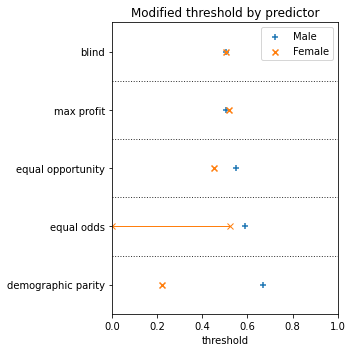

In [272]:
t = thresholds.copy()
# t.loc['equal odds'] = None
t = t.reindex(['blind', 'max profit', 'equal opportunity', 'equal odds', 'demographic parity']).iloc[::-1, :]
t.loc['equal odds', 'Male'] = male_eodd_th
n_rows = t.shape[0]
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x=t['Male'], y=t.index, label='Male', marker='+')
f = ax.scatter(x=t['Female'], y=t.index, label='Female', marker='x')
ax.plot([0, female_eodd_th], [t.index.get_loc('equal odds'), t.index.get_loc('equal odds')], color='tab:orange', marker='x', linewidth=1)
# f.set_offsets((10, 10))
ax.legend()
ax.set_xlim(0, 1)
for i in range(n_rows - 1):
    ax.axhline(y=0.5 + i, linestyle=':', c='#333', linewidth=1)
ax.set_ylim(-0.5, 0.5 + n_rows - 1)
ax.set_xlabel('threshold')
ax.set_title('Modified threshold by predictor')
fig.tight_layout()
fig.savefig('thresholds.png', dpi=300)

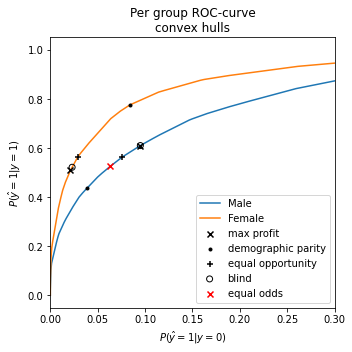

In [134]:
fig, ax = plt.subplots(figsize=(5, 5))
for curve in curves:
    ax.plot(curve.fps, curve.tps, label=curve.label, zorder=1)
for c, curve in enumerate(curves):
    ax.scatter(mp[2][c], mp[1][c], color='k', marker='x', label='max profit' if c == 0 else None)
    ax.scatter(ed[2][c], ed[1][c], color='k', marker='.', label='demographic parity' if c == 0 else None)
    ax.scatter(eopp[2][c], eopp[1][c], color='k', marker='+', label='equal opportunity' if c == 0 else None)
    _tp, _fp = lookup_to_tp_fp(bm[2], curve.ths[::-1], curve.tps[::-1], curve.fps[::-1])
    m = ax.scatter(_fp, _tp, color='k', marker='o', label='blind' if c == 0 else None)
    m.set_facecolor('none')
ax.scatter(eodd[1], eodd[0], color='red', marker='x', label='equal odds')
ax.legend(loc='lower right')
ax.set_ylabel('$P(\hat{y}=1|y=1)$')
ax.set_xlabel('$P(\hat{y}=1|y=0)$')
ax.set_title('Per group ROC-curve\nconvex hulls')
ax.set_xlim(0, 0.3)
fig.tight_layout()

fig.savefig('curves-zoomed.png', dpi=300)

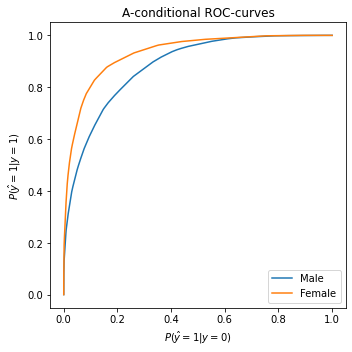

In [138]:
fig, ax = plt.subplots(figsize=(5, 5))
for curve in curves:
    ax.plot(curve.fps, curve.tps, label=curve.label, zorder=1)
# for c, curve in enumerate(curves):
#     ax.scatter(mp[2][c], mp[1][c], color='k', marker='x', label='max profit' if c == 0 else None)
#     ax.scatter(ed[2][c], ed[1][c], color='k', marker='.', label='demographic parity' if c == 0 else None)
#     ax.scatter(eopp[2][c], eopp[1][c], color='k', marker='+', label='equal opportunity' if c == 0 else None)
#     _tp, _fp = lookup_to_tp_fp(bm[2], curve.ths[::-1], curve.tps[::-1], curve.fps[::-1])
#     m = ax.scatter(_fp, _tp, color='k', marker='o', label='blind' if c == 0 else None)
#     m.set_facecolor('none')
# ax.scatter(eodd[1], eodd[0], color='red', marker='x', label='equal odds')
ax.legend(loc='lower right')
ax.set_ylabel('$P(\hat{y}=1|y=1)$')
ax.set_xlabel('$P(\hat{y}=1|y=0)$')
ax.set_title('A-conditional ROC-curves')
# ax.set_xlim(0, 0.3)
fig.tight_layout()

fig.savefig('rocs.png', dpi=300)

In [74]:
eodd

(0.5250673141627535, 0.06326010647013411)

0.5236138096134295

In [94]:
intersection_threshold(curves[0], *eodd)

0.5872496052093773

In [86]:
curve = curves[0]

tp, fp = eodd
def line(x: float) -> float:
    return (1 - tp) / (1 - fp) * (x - 1) + 1

ys = np.array([line(p) for p in curve.fps])
i = np.argmax(ys - curve.tps < 0)
phi = (1 - tp) / (1 - fp)
x1 = curve.fps[i-1]
x2 = curve.fps[i]
y1 = curve.tps[i-1]
y2 = curve.tps[i]



In [87]:
x1, y1

(0.06259915388683236, 0.5229660762533773)

In [88]:
x2, y2

(0.06326017979904812, 0.5250675472830981)

In [198]:
eodd

(0.5250673141627535, 0.06326010647013411)

In [95]:
intersection_threshold(curves[1], *eodd)

0.5236138096134295

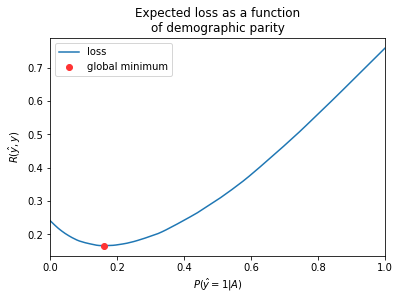

In [156]:
def neg_loss_ac_parity(v: float) -> float:
    l = 0
    for curve in curves:
        v_tp, v_fp = lookup_to_tp_fp(v, curve.acs, curve.tps, curve.fps)
        l += loss(v_tp, v_fp, curve.pi) * curve.share
    return -l

x = np.linspace(0, 1, num=1000)
y = np.array([-neg_loss_ac_parity(v) for v in x])

i = y.argmin()


fig, ax = plt.subplots()

ax.plot(x, y, label='loss', zorder=1)
ax.set_xlabel('$P(\hat{y}=1|A)$')
ax.set_ylabel('$R(\hat{y}, y)$')
ax.scatter(x[i], y[i], label='global minimum', c='#f33')
ax.set_title('Expected loss as a function\nof demographic parity')
ax.legend()
ax.set_xlim(0, 1)

fig.savefig('loss-vs-demographic.png', dpi=300)


# test data metrics

In [256]:
x_test, y_test, labels_test, label_map_test = preprocess(
    fname='adult.test',
    col_names=col_names,
    protected='sex'
)

In [257]:
y.mean()

0.2408095574460244

In [162]:
probs_test = model.predict_proba(x_test)[:, 1]

In [259]:
# max profit
out = []
for c, th in enumerate(mp[0]):
    mask = labels_test == c
    probs_test_c = probs_test[mask]
    y_test_c = y_test[mask]
    preds = probs_test_c >= th
    correct = preds == y_test_c
    out.append(correct)
    # corrects = np.concatenate([corrects, correct])
corrects = np.concatenate(out)
mp_test_accuracy = corrects.mean()
1 - mp_test_accuracy


0.14882378232295312

In [260]:
# blind
preds = probs_test >= bm[-1]
bm_test_accuracy = (preds == y_test).mean()
1 - bm_test_accuracy

0.14870093974571585

In [261]:
# demographic parity
out = []
for c, th in enumerate(ed[-1]):
    mask = labels_test == c
    probs_test_c = probs_test[mask]
    y_test_c = y_test[mask]
    preds = probs_test_c >= th
    correct = preds == y_test_c
    out.append(correct)
    # corrects = np.concatenate([corrects, correct])
corrects = np.concatenate(out)
ed_test_accuracy = corrects.mean()
1 - ed_test_accuracy

0.1695227565874332

In [262]:
# equal opportunity
out = []
for c, th in enumerate(eopp[-1]):
    mask = labels_test == c
    probs_test_c = probs_test[mask]
    y_test_c = y_test[mask]
    preds = probs_test_c >= th
    correct = preds == y_test_c
    out.append(correct)
    # corrects = np.concatenate([corrects, correct])
corrects = np.concatenate(out)
eopp_test_accuracy = corrects.mean()
1 - eopp_test_accuracy

0.14906946747742766

In [263]:
# equal odds

In [264]:
l = 0
f = eodd[-1]
for c, curve in enumerate(curves):

    tp, fp = lookup_to_tp_fp(f, curve.fps, curve.tps, curve.fps)
    print(tp, fp)
    sr = (f - fp) / (1 - fp)
    print(sr)

0.5250673141627535 0.06326010647013411
0.0
0.7169145572695573 0.06326010647013411
0.0


In [265]:
curve.label

'Female'

In [266]:
lookup_to_tp_fp(female_eodd_th, curve.ths[::-1], curve.tps[::-1], curve.fps[::-1])

(0.5037769265586717, 0.020703661708306578)

In [267]:
# eodd test loss
l = 0
for th, curve in zip([male_eodd_th, female_eodd_th], curves):
    tp, fp = lookup_to_tp_fp(th, curve.ths[::-1], curve.tps[::-1], curve.fps[::-1])
    sr = (eodd[-1] - fp ) / (1 - fp)
    if abs(sr) < 1e-6:
        pred = probs_test >= th
        correct = (pred == y_test) * 1
        print(f'{curve.label}: {1 - correct.mean()}')
        l += (1 - correct.mean()) * curve.share
    else:
        mask = probs_test >= th
        a = mask.mean()
        b = y_test[mask].mean()
        c = 1 - b
        d = 1 - y_test[~mask].mean()
        change = sr * d * (1 - a) + c * a + (1 - sr) * b * a
        print(f'{curve.label}: {change}')
        l += change * curve.share
eodd_test_loss = l
l

Male: 0.15146489773355443
Female: 0.20515822352522733


0.16922635506293957

In [268]:
train_loss = loss_table.copy()
train_loss.name = 'train loss'
losses = pd.DataFrame(train_loss)
losses.loc['max profit', 'test loss'] = 1 - mp_test_accuracy
losses.loc['blind', 'test loss'] = 1 - bm_test_accuracy
losses.loc['demographic parity', 'test loss'] = 1 - ed_test_accuracy
losses.loc['equal opportunity', 'test loss'] = 1 - eopp_test_accuracy
losses.loc['equal odds', 'test loss'] = eodd_test_loss
losses

,train loss,test loss
predictor,,
blind,0.148245,0.148701
max profit,0.148061,0.148824
demographic parity,0.166380,0.169523
equal opportunity,0.149047,0.149069
equal odds,0.162395,0.169226


In [269]:
print(losses.to_latex(float_format='%.4f'))

\begin{tabular}{lrr}
\toprule
{} &  train loss &  test loss \\
predictor          &             &            \\
\midrule
blind              &      0.1482 &     0.1487 \\
max profit         &      0.1481 &     0.1488 \\
demographic parity &      0.1664 &     0.1695 \\
equal opportunity  &      0.1490 &     0.1491 \\
equal odds         &      0.1624 &     0.1692 \\
\bottomrule
\end{tabular}



/var/folders/nc/dhtws2m1317bwzbsxq9n3_gc0000gn/T/ipykernel_1900/3063318810.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(losses.to_latex(float_format='%.4f'))


In [220]:
curve.share

0.33079450876815825

In [217]:
y

array([False, False, False, ...,  True, False,  True])

In [202]:
curve.fps

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.04253545e-04,
       7.29774812e-04, 1.45954962e-03, 2.50208507e-03, 8.23603003e-03,
       8.54879066e-03, 1.11551293e-02, 1.30316931e-02, 1.59507923e-02,
       2.12677231e-02, 2.86697248e-02, 2.89824854e-02, 3.21100917e-02,
       4.07631359e-02, 6.38031693e-02, 7.39157631e-02, 8.12135113e-02,
       8.40283570e-02, 1.14157631e-01, 1.16346956e-01, 1.20829858e-01,
       1.58361134e-01, 1.62322769e-01, 1.87239366e-01, 1.88803169e-01,
       2.61363636e-01, 3.23915763e-01, 3.44974979e-01, 3.53628023e-01,
       4.21809842e-01, 4.39845705e-01, 5.27418682e-01, 6.95996664e-01,
       7.55838198e-01, 8.67806505e-01, 8.67910759e-01, 8.68119266e-01,
       8.68744787e-01, 8.68953294e-01, 8.69683069e-01, 8.70725605e-01,
       8.71038365e-01, 8.71351126e-01, 8.72706422e-01, 8.72914929e-01,
       8.73123436e-01, 8.74687239e-01, 8.76146789e-01, 8.76355296e-01,
       8.77502085e-01, 8.78336113e-01, 8.78440367e-01, 8.78648874e-01,
      

/Users/leevi/.pyenv/versions/3.10.4/envs/ml-venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/leevi/.pyenv/versions/3.10.4/envs/ml-venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


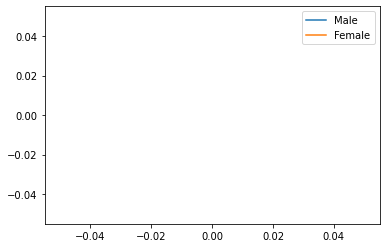

In [229]:
fig, ax = plt.subplots()

for c, curve in enumerate(curves):
    mask = labels_test == c
    ps = probs_test[mask]
    ys = y_test[mask]
    fp, tp, th = metrics.roc_curve(ys, ps)
    ax.plot(fp, tp, label=curve.label)

ax.legend()

In [239]:
x.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456,0.056386,0.029483,0.064279,0.000215,0.697030,...,0.255060,0.030128,0.155646,0.105832,0.048156,0.009551,0.031909,0.095943,0.008323,0.854274
std,13.640433,2.572720,7385.292085,402.960219,12.347429,0.230670,0.169159,0.245254,0.014661,0.459549,...,0.435901,0.170942,0.362525,0.307627,0.214099,0.097264,0.175761,0.294518,0.090851,0.352837
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [240]:
x_test.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
count,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,...,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,10.072907,1081.905104,87.899269,40.392236,0.059149,0.028991,0.064062,0.000184,0.688533,...,0.262760,0.032246,0.154352,0.103126,0.046864,0.009766,0.029482,0.095879,0.008292,0.856581
std,13.849187,2.567545,7583.935968,403.105286,12.479332,0.235910,0.167786,0.244872,0.013574,0.463108,...,0.440147,0.176659,0.361297,0.304133,0.211355,0.098342,0.169159,0.294434,0.090684,0.350510
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,90.000000,16.000000,99999.000000,3770.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [243]:
%pip install seaborn

24838.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 2.8 MB/s eta 0:00:00 MB/s eta 0:00:01

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [244]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

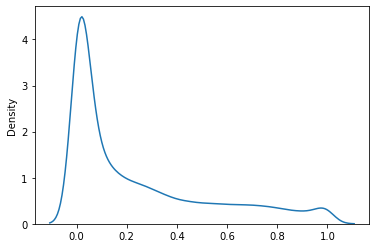

In [245]:
sns.kdeplot(probs)

<AxesSubplot:ylabel='Density'>

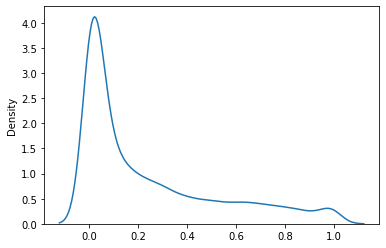

In [246]:
sns.kdeplot(probs_test)

In [251]:
y_test.mean()

0.0

<AxesSubplot:>

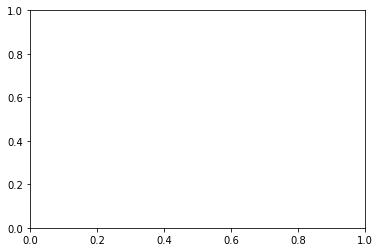

In [249]:
sns.kdeplot(probs_test[y_test == 1])

<AxesSubplot:ylabel='Density'>

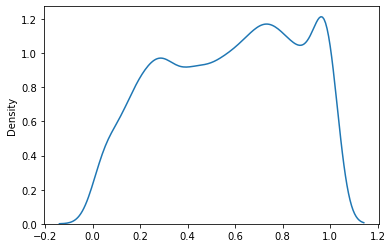

In [248]:
sns.kdeplot(probs[y == 1])
sns.kdeplot(probs_test[y_test == 1])